In [30]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
idx = pd.IndexSlice
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [31]:
tickers = [
    "TCS.NS",       # Tata Consultancy Services Ltd.
    "INFY.NS",      # Infosys Ltd.
    "WIPRO.NS",     # Wipro Ltd.
    "HCLTECH.NS",   # HCL Technologies Ltd.
    "TECHM.NS",     # Tech Mahindra Ltd.
    "LT.NS",        # Larsen & Toubro Infotech Ltd.
    "TATAELXSI.NS",  # Mindtree Ltd.
    "MPHASIS.NS",   # Mphasis Ltd.
    "TECHM.NS",      # Oracle Financial Services Software Ltd.
    "COFORGE.NS"    # Coforge Ltd. (formerly NIIT Technologies Ltd.)
]

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(tickers, start="2022-01-01", end="2023-01-01")['Adj Close']
close = yf.download(tickers, start="2022-01-01", end="2023-01-01")['Adj Close']
train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


Text(0.5, 1.0, 'Assets Correlation Matrix')

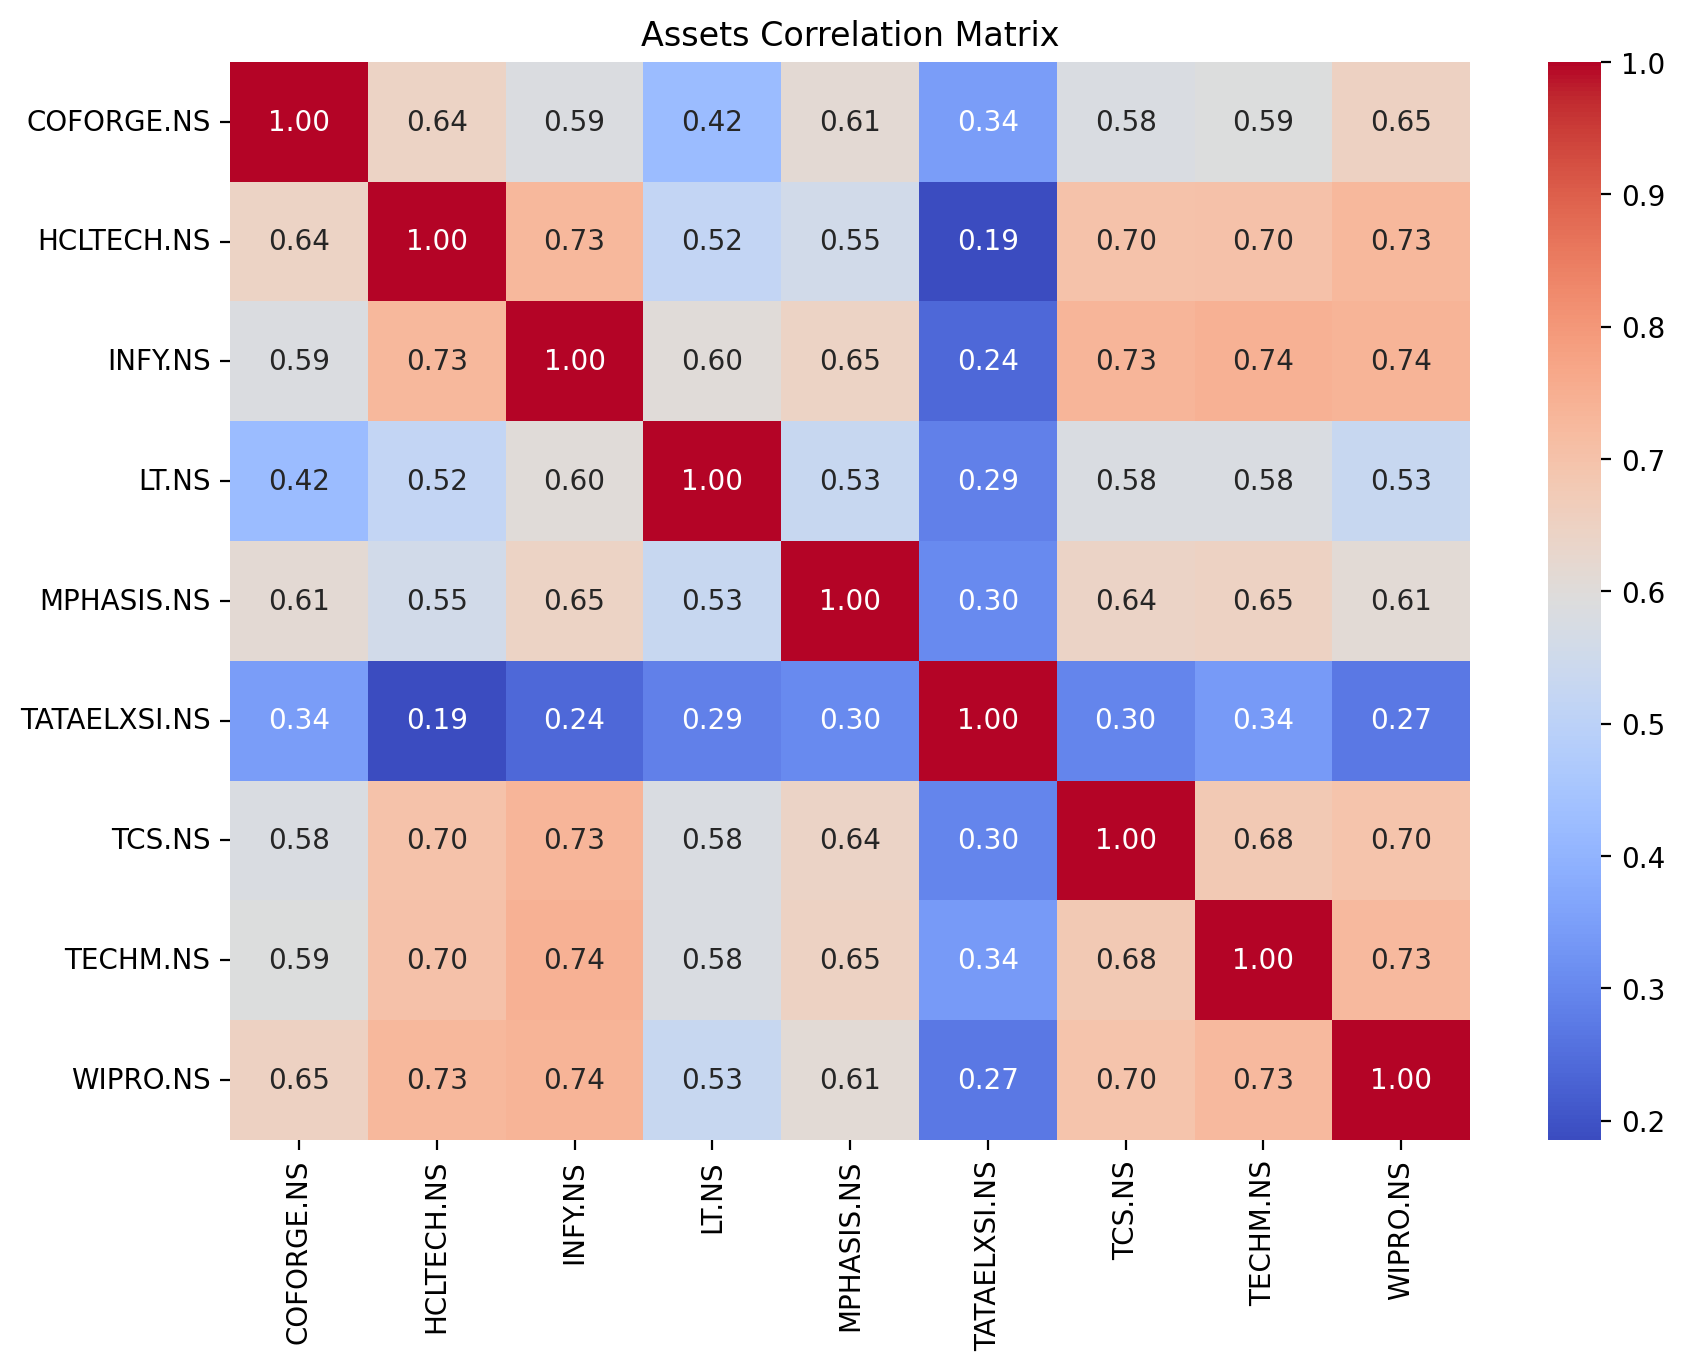

In [32]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')


In [33]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('COFORGE.NS', 'LT.NS'), ('COFORGE.NS', 'TCS.NS'), ('HCLTECH.NS', 'LT.NS'), ('HCLTECH.NS', 'TCS.NS'), ('HCLTECH.NS', 'WIPRO.NS'), ('LT.NS', 'TCS.NS'), ('TCS.NS', 'TECHM.NS')]


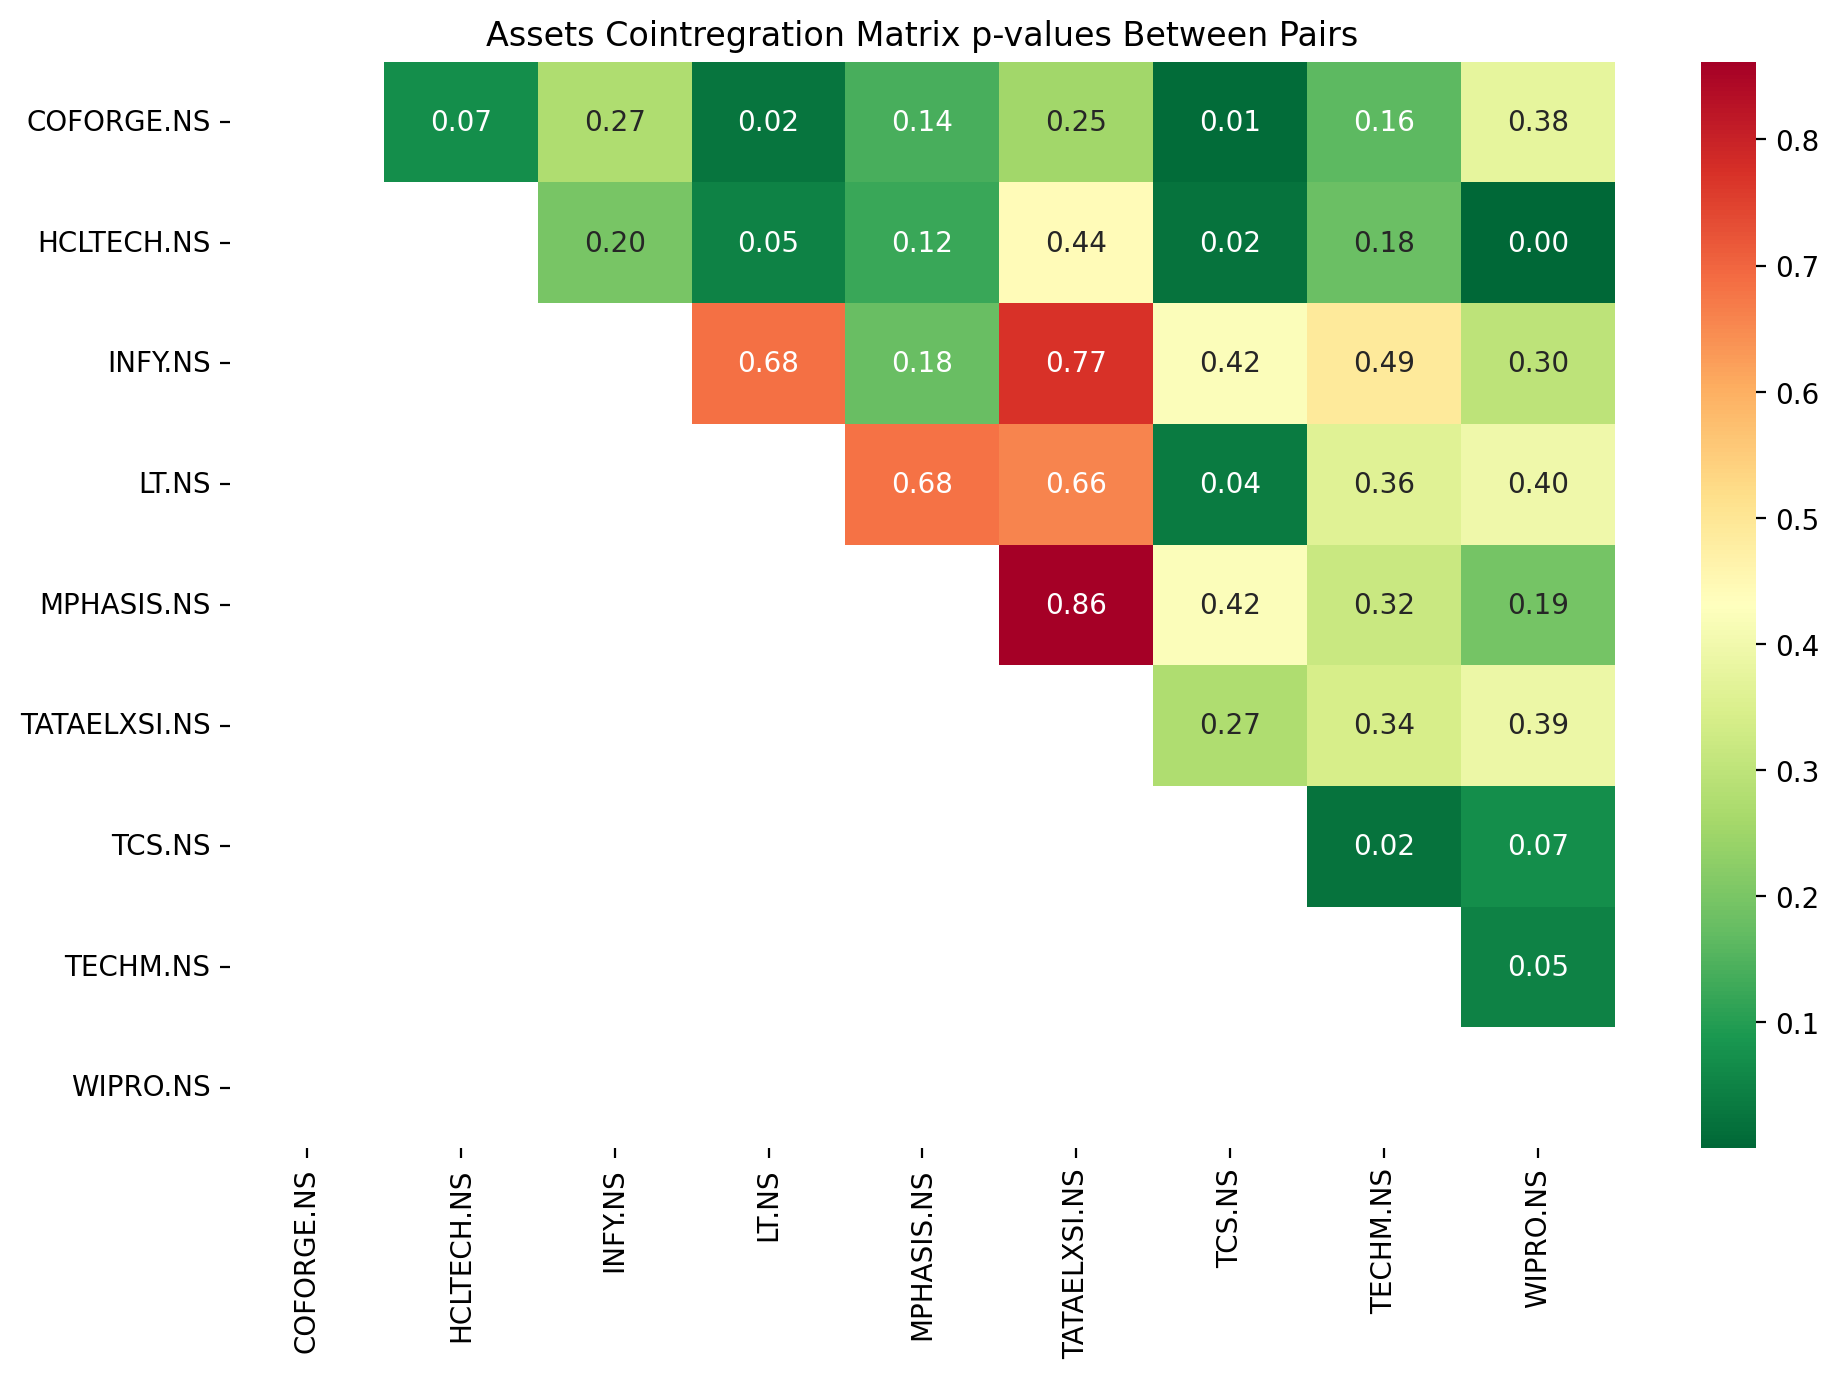

In [34]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()


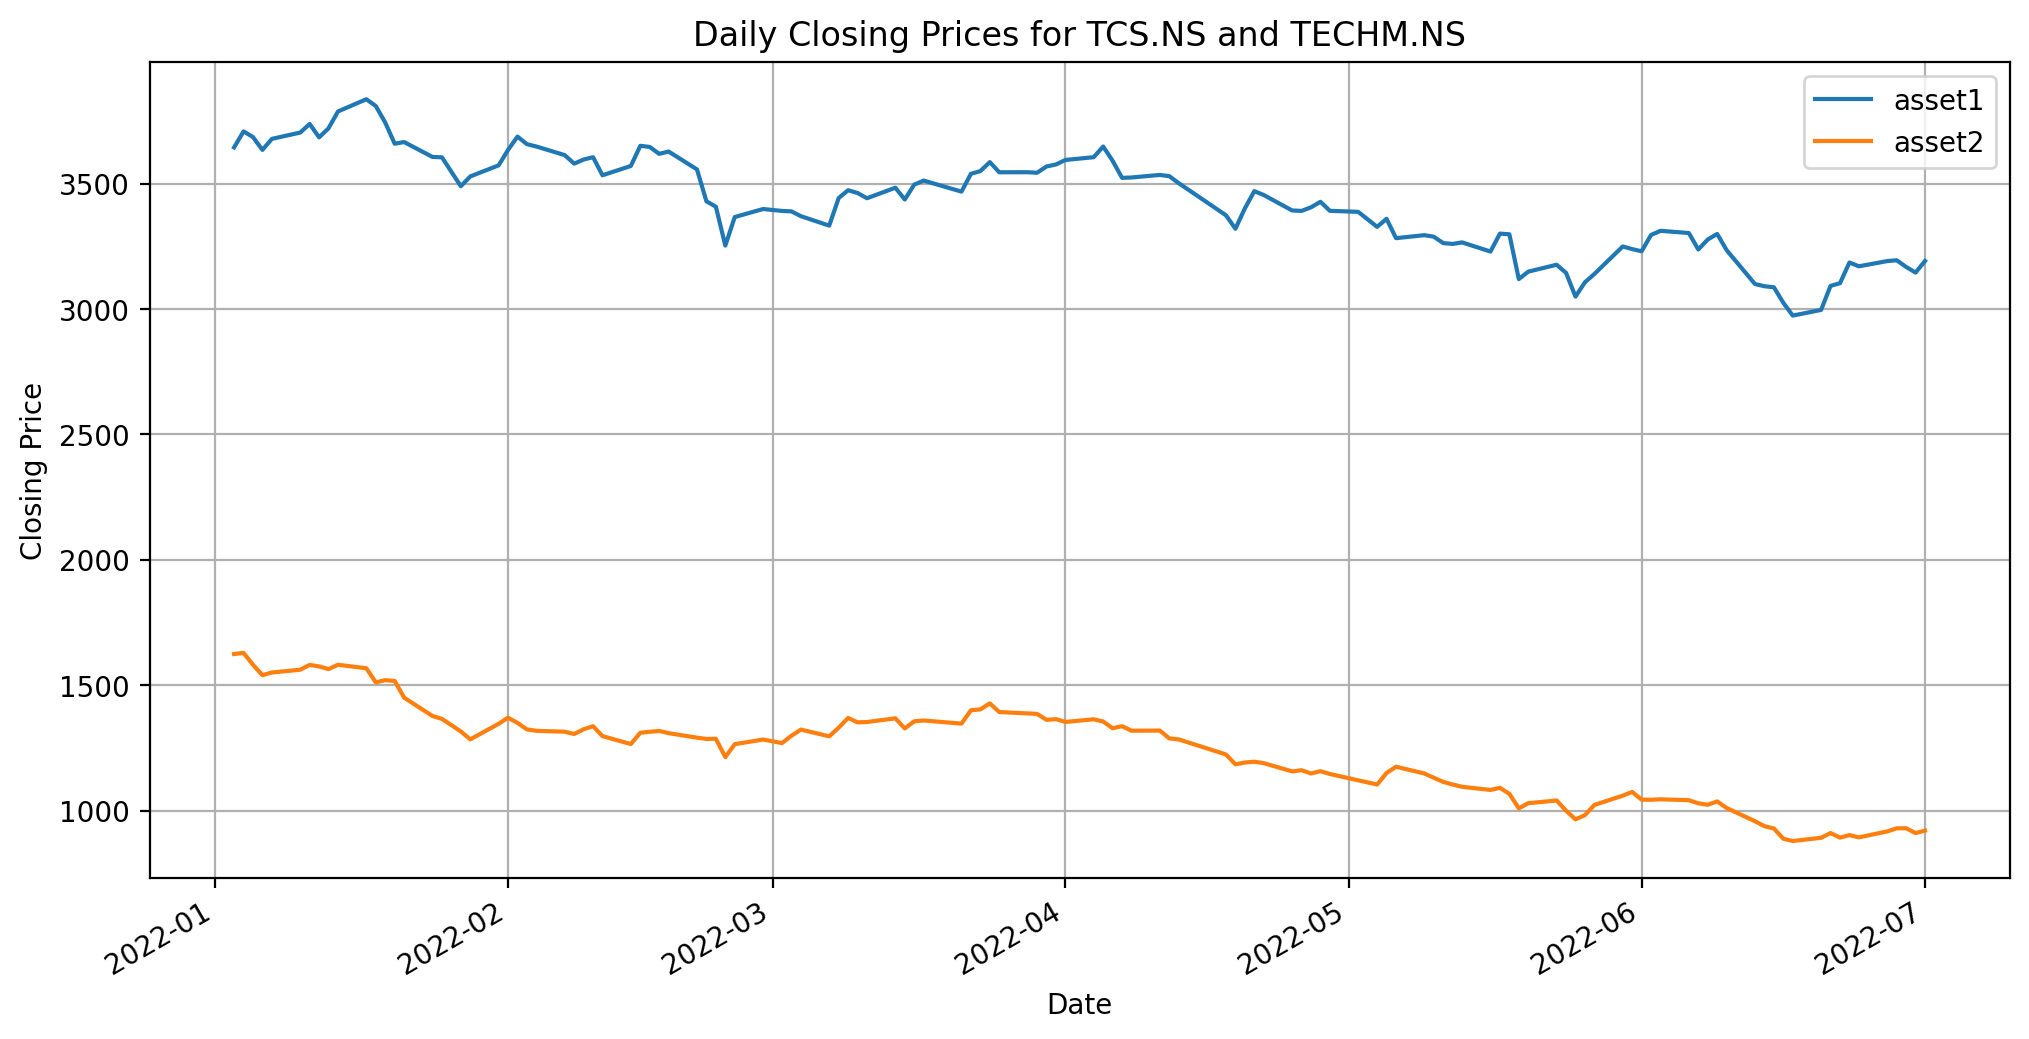

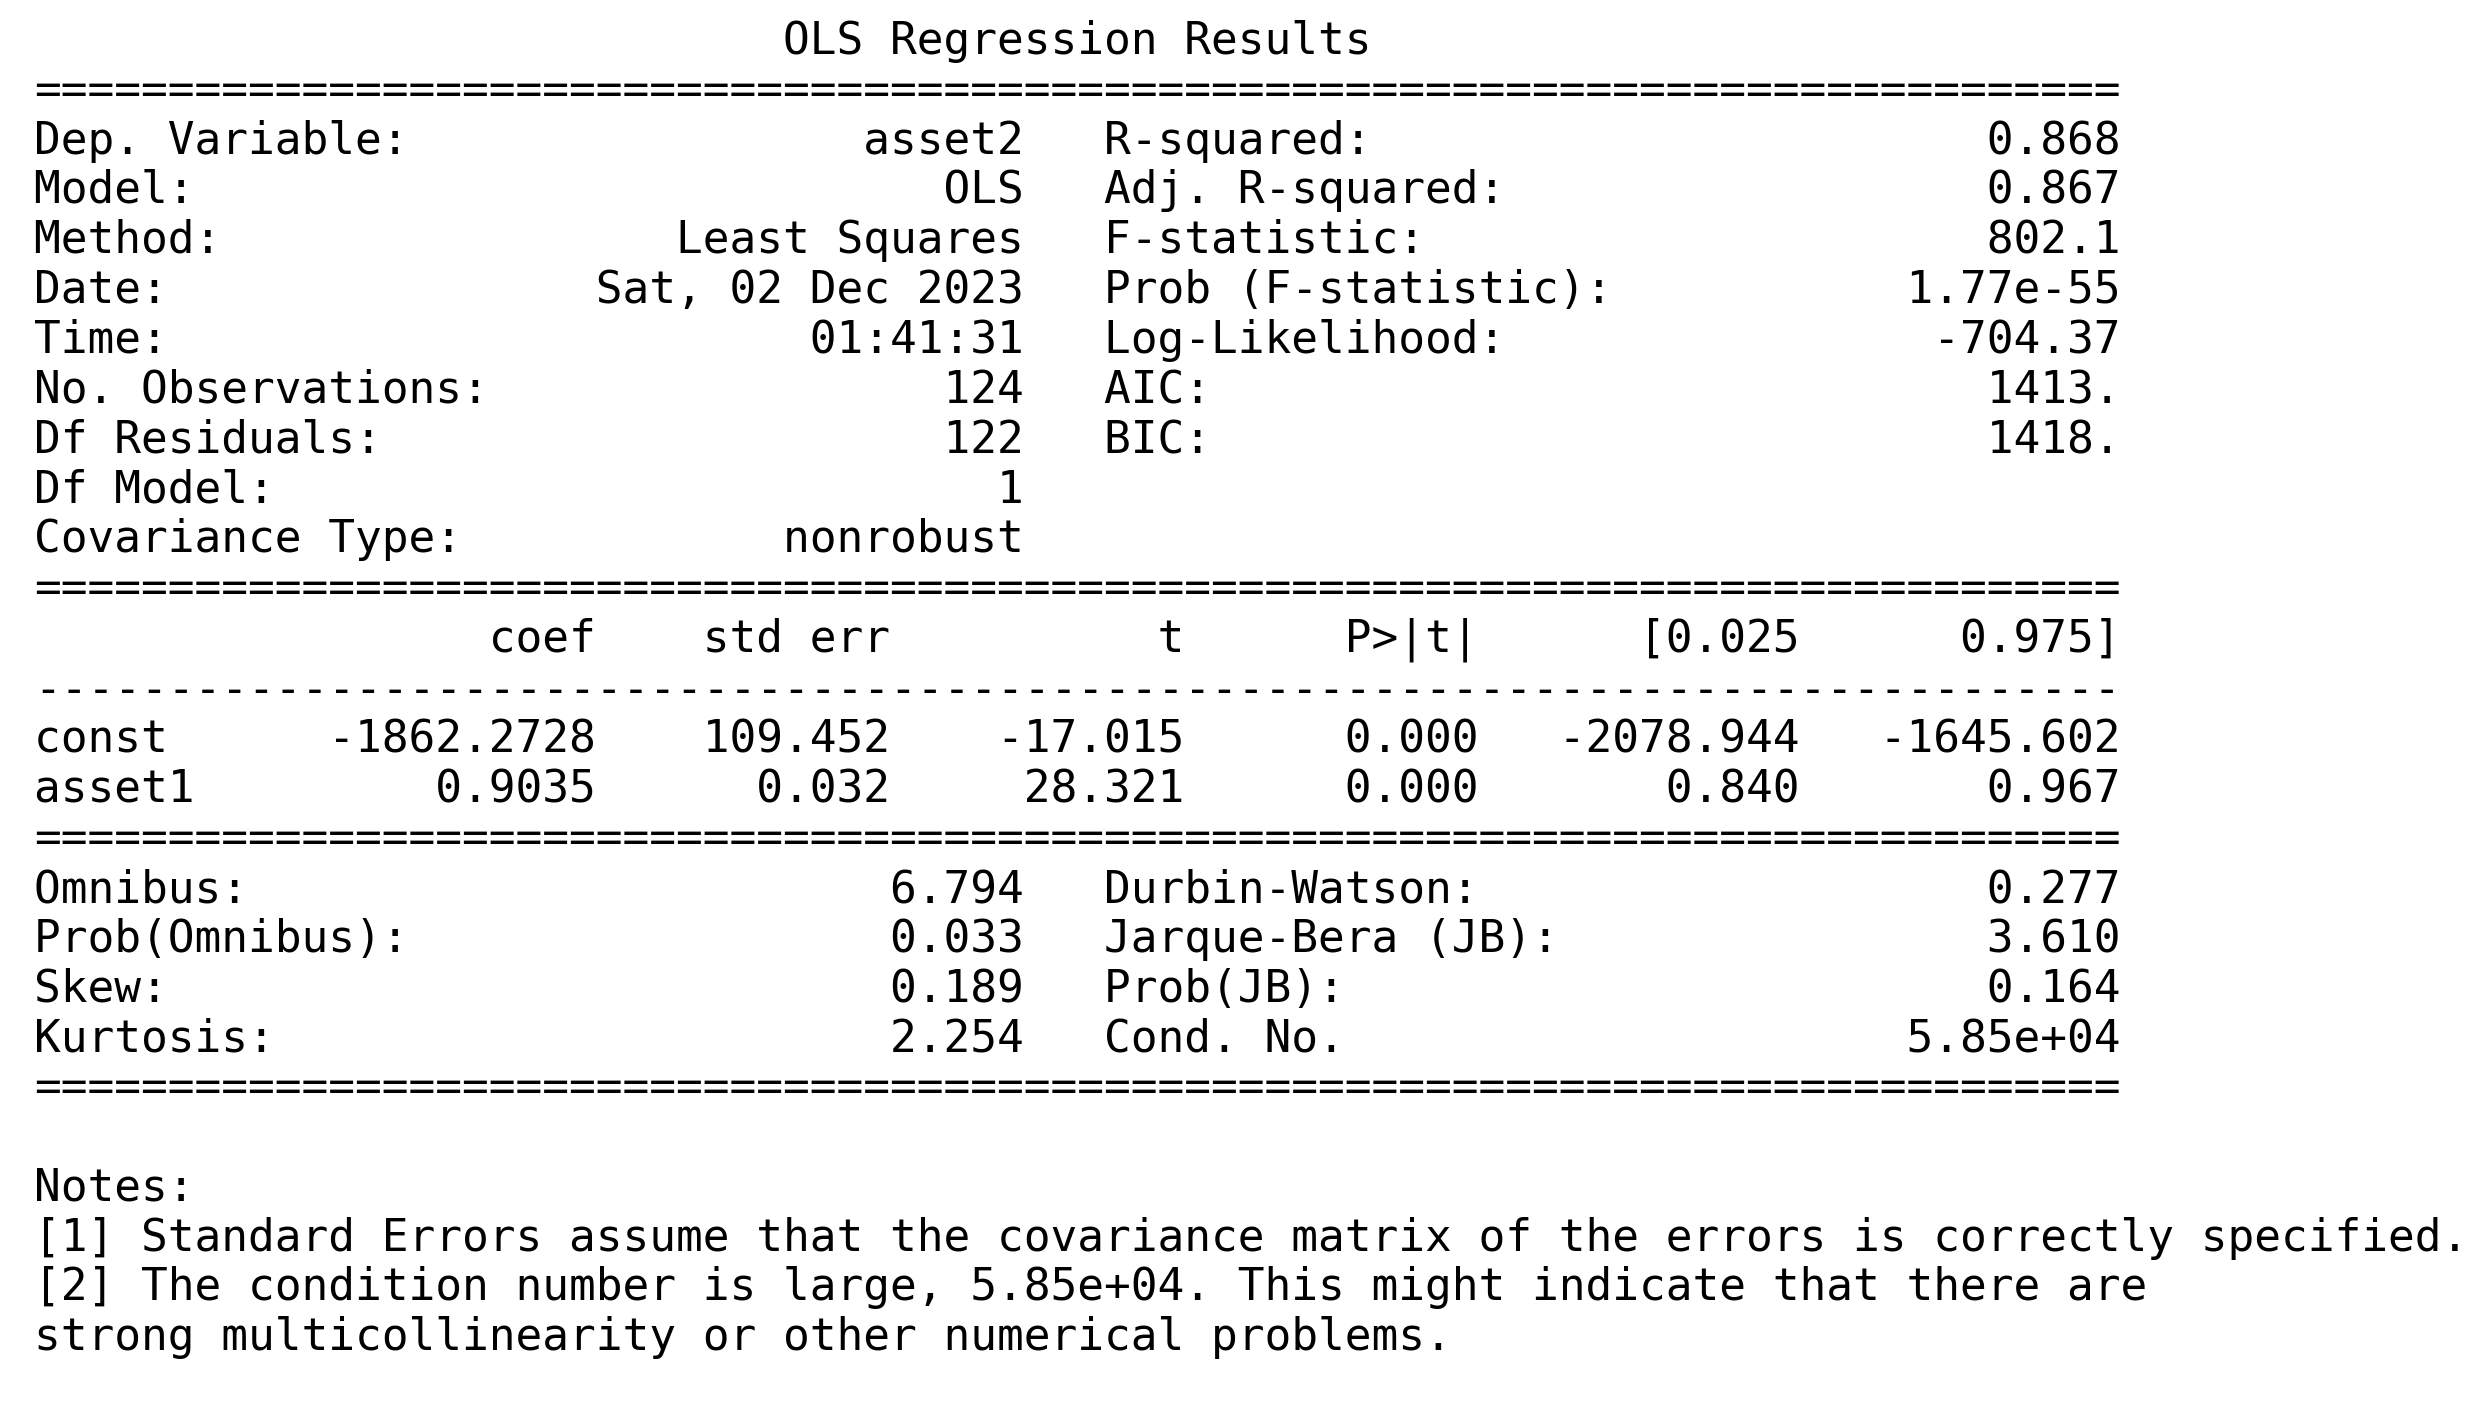

Hedge Ratio =  0.9034501844288096


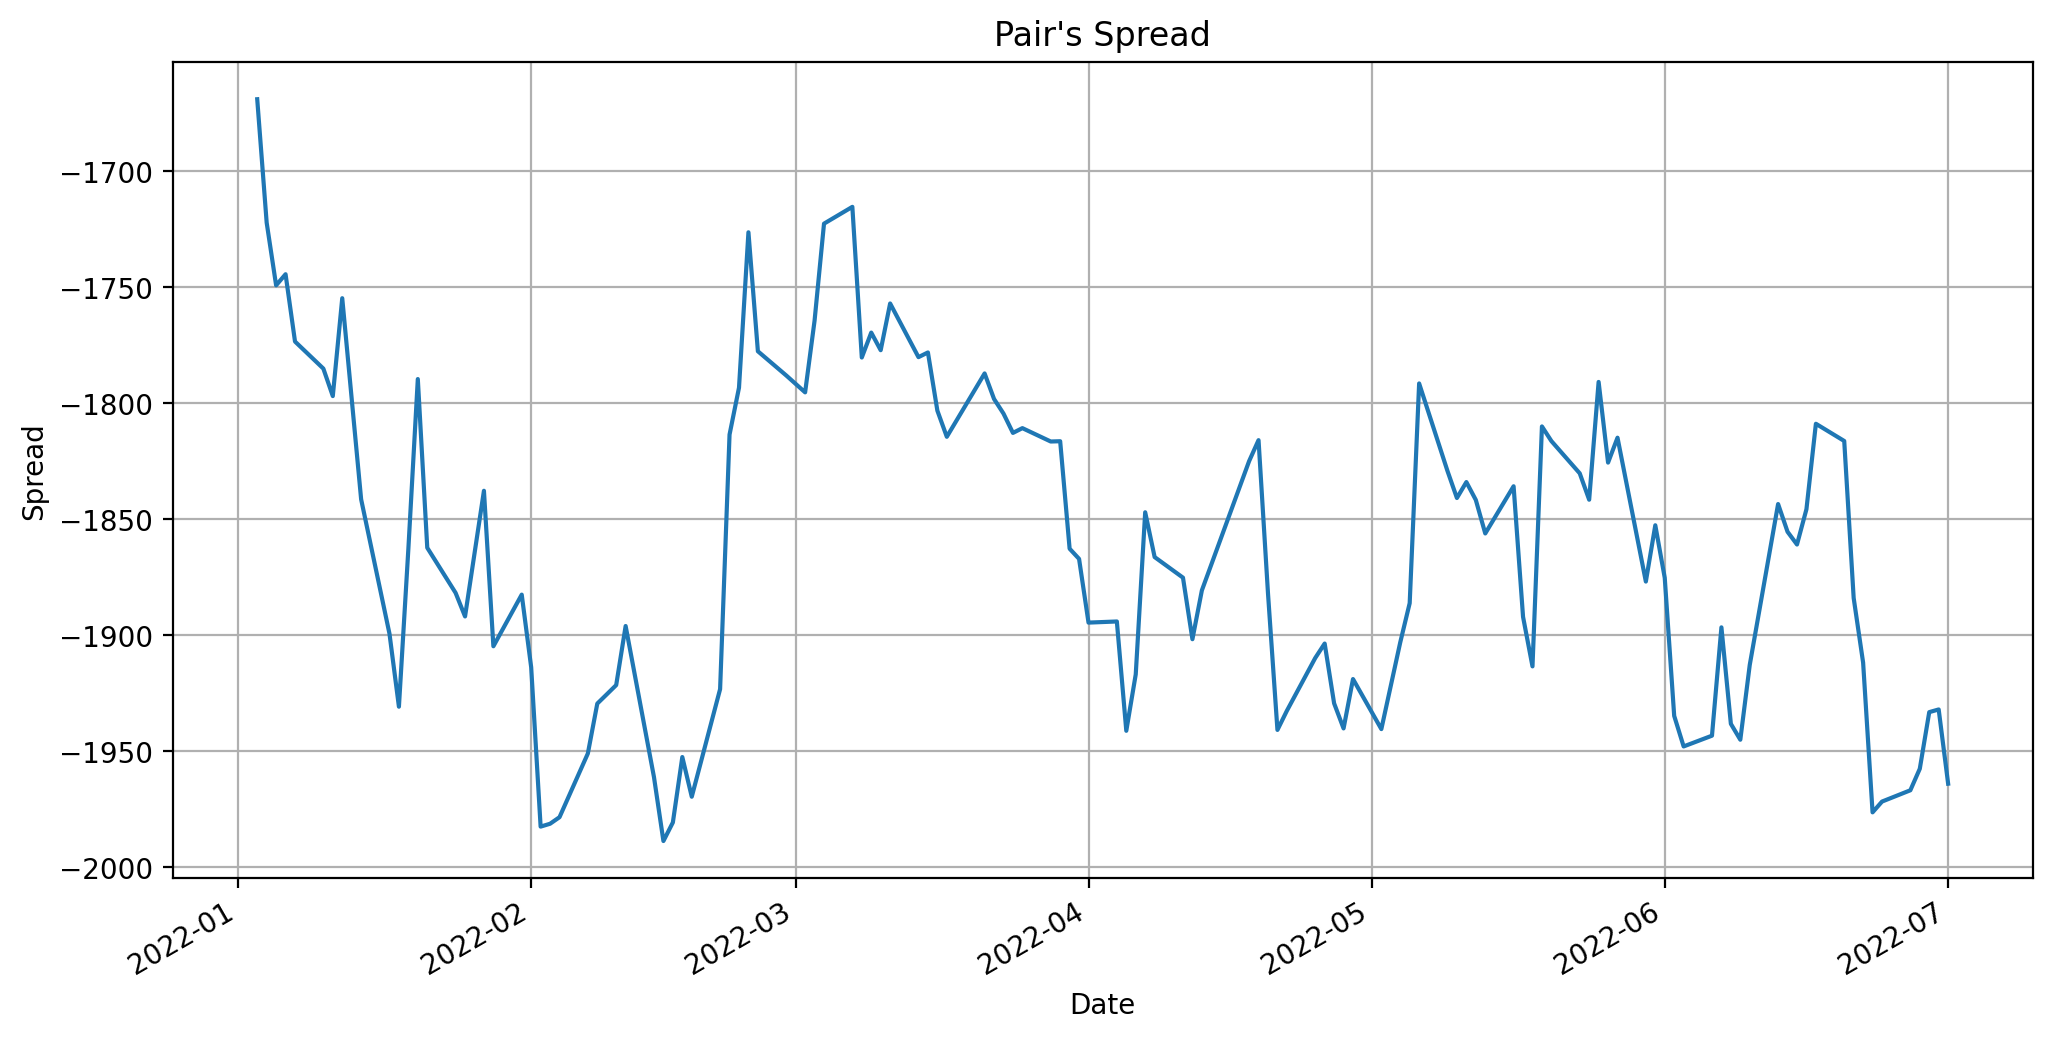

ADF Statistic =  -3.5452056045580296
p-value =  0.006899242549630474
Critical Values =  {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}


In [35]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Assuming you have the 'train_close' DataFrame with the closing prices of all assets

# Final pair to test the strategy
asset1 = 'TCS.NS'
asset2 = 'TECHM.NS'

# Create a train DataFrame of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

# Visualize closing prices
ax = train[['asset1', 'asset2']].plot(figsize=(12, 6), title='Daily Closing Prices for {} and {}'.format(asset1, asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

plt.show()  # Show the plot before proceeding

# Run OLS regression
model = sm.OLS(train.asset2, sm.add_constant(train.asset1)).fit()

# Print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties='monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

plt.show()  # Show the plot before proceeding

print('Hedge Ratio = ', model.params[1])

# Calculate spread
spread = train.asset2 - model.params[1] * train.asset1

# Plot the spread
ax = spread.plot(figsize=(12, 6), title="Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True)

plt.show()  # Show the plot before proceeding

# Conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag=1)
print('ADF Statistic = ', adf[0])
print('p-value = ', adf[1])
print('Critical Values = ', adf[4])


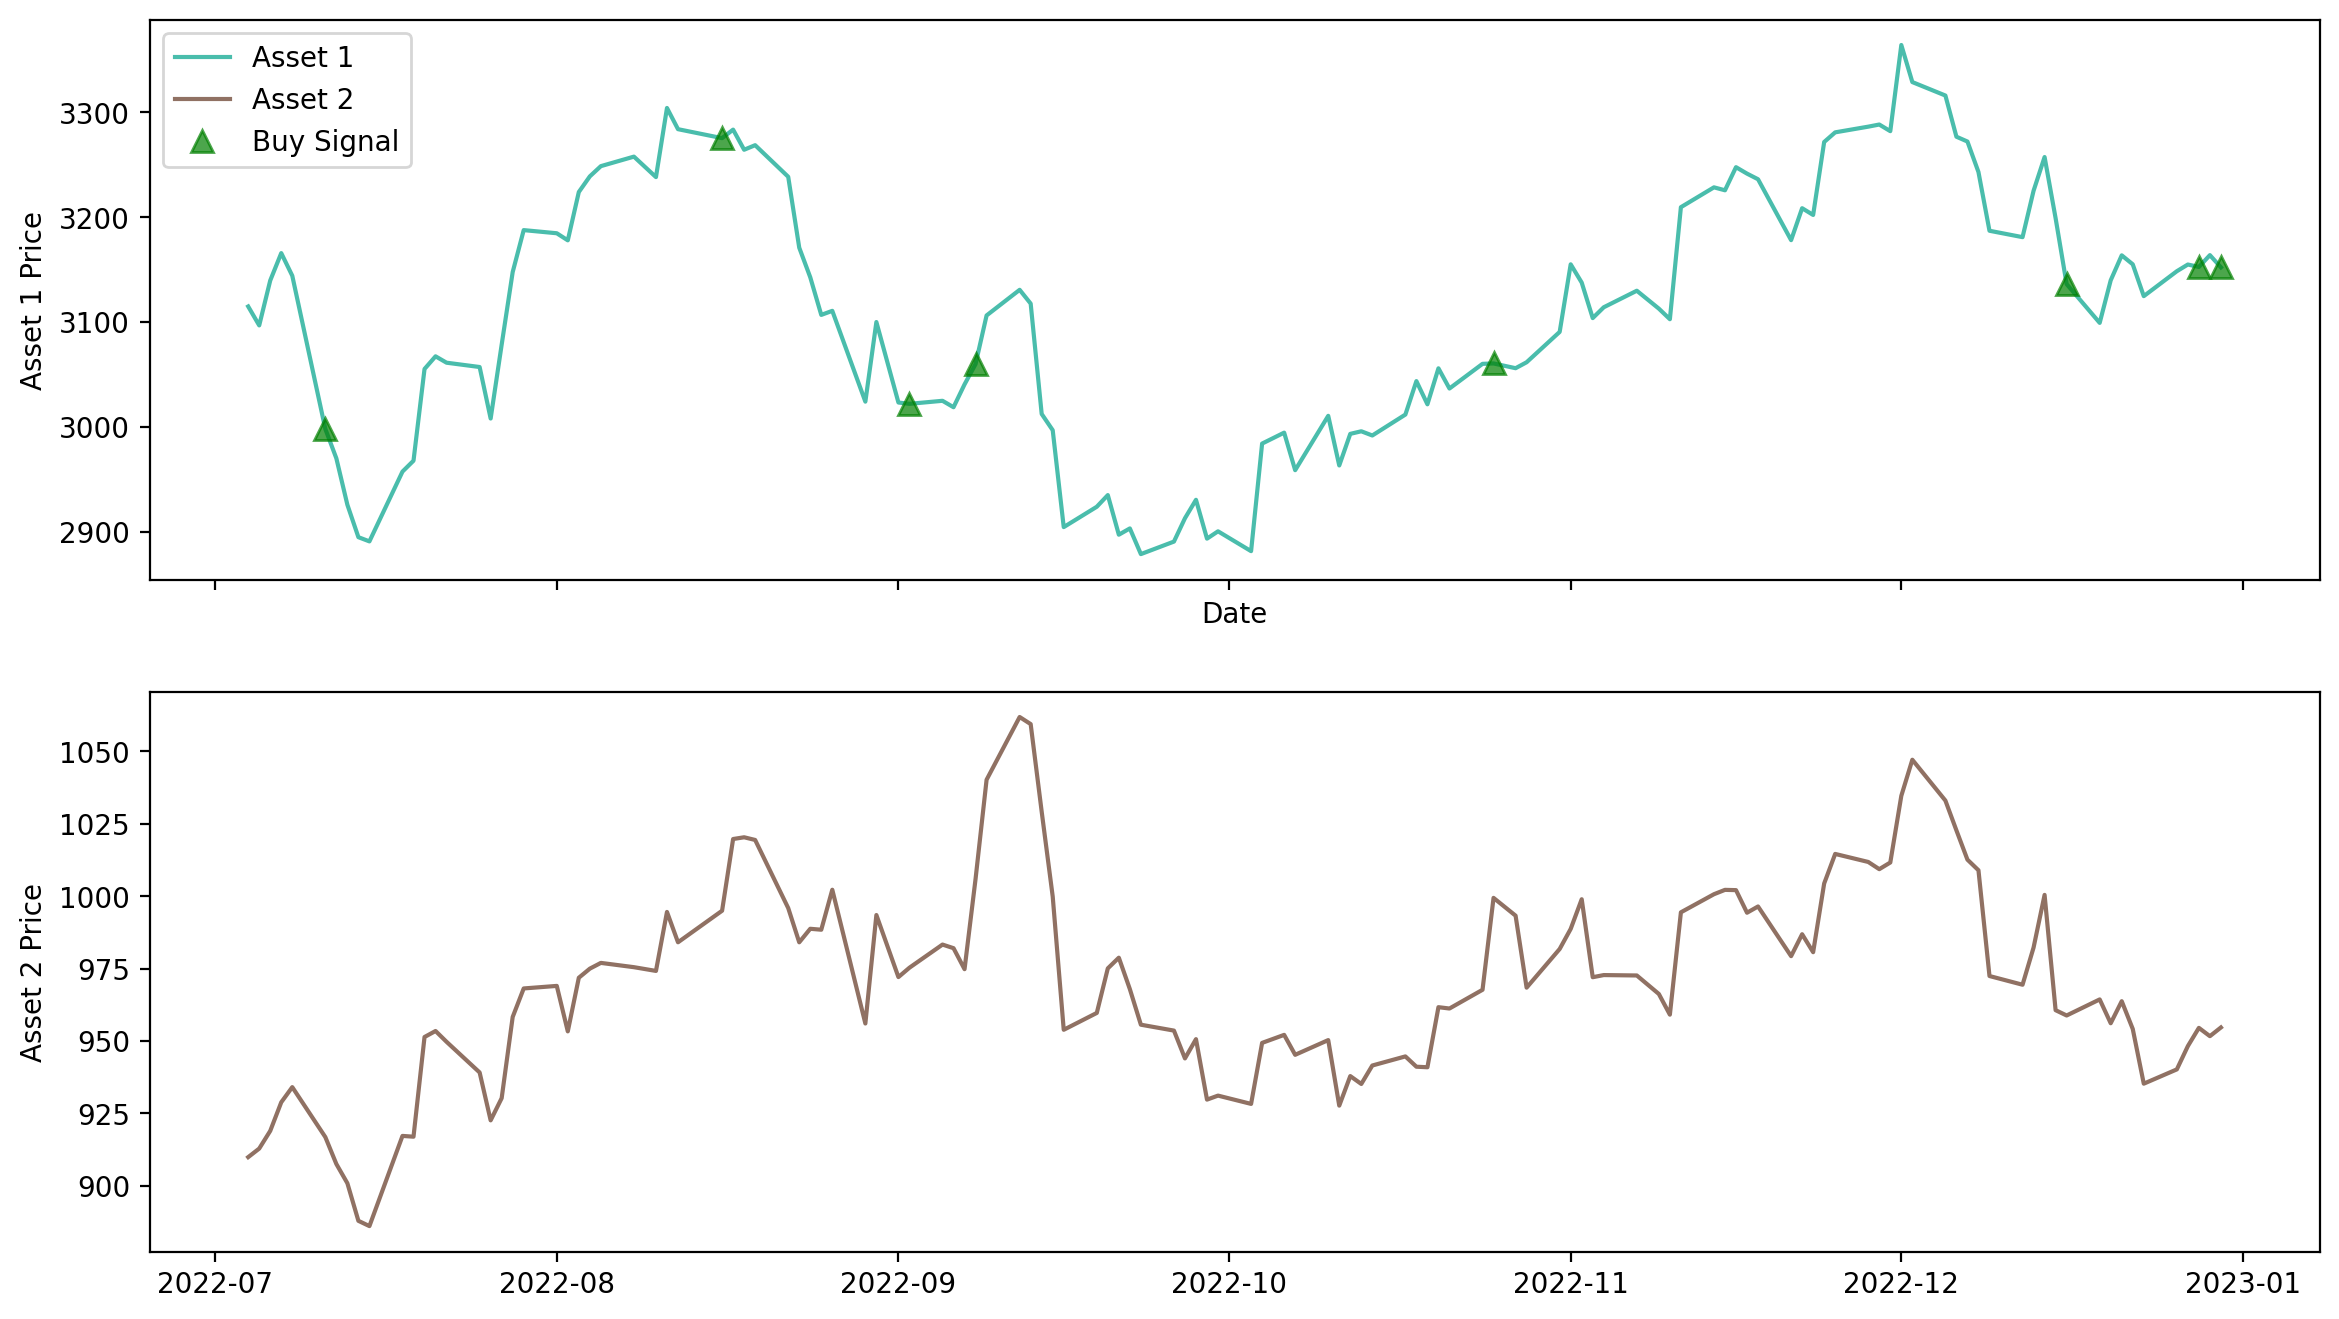

In [36]:
# calculate z-score
def zscore(series):
 return (series-series.mean()) / np.std(series)
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()
# visualize trading signals and position
fig, (bx, bx2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot asset1 and asset2 on the first axis
l1, = bx.plot(signals['asset1'], c='#4abdac', label='Asset 1')
l2, = bx2.plot(signals['asset2'], c='#907163', label='Asset 2')

# Plot signals for asset1 on the first axis
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g', alpha=0.7)

# Set labels and legend
bx.set_ylabel('Asset 1 Price')
bx2.set_ylabel('Asset 2 Price')
bx.set_xlabel('Date')
bx.legend(handles=[l1, l2, u1], labels=['Asset 1', 'Asset 2', 'Buy Signal'], loc='upper left')

# Show the plot
plt.show()

# # verify datafame head and tail
# signals.head(3).append(signals.tail(3))
# # visualize trading signals and position
# fig=plt.figure(figsize=(14,6))
# bx = fig.add_subplot(111)   
# bx2 = bx.twinx()
# #plot two different assets
# l1, = bx.plot(signals['asset1'], c='#4abdac')
# l2, = bx2.plot(signals['asset2'], c='#907163')
# u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

Number of days =  177
CAGR = 366.972%


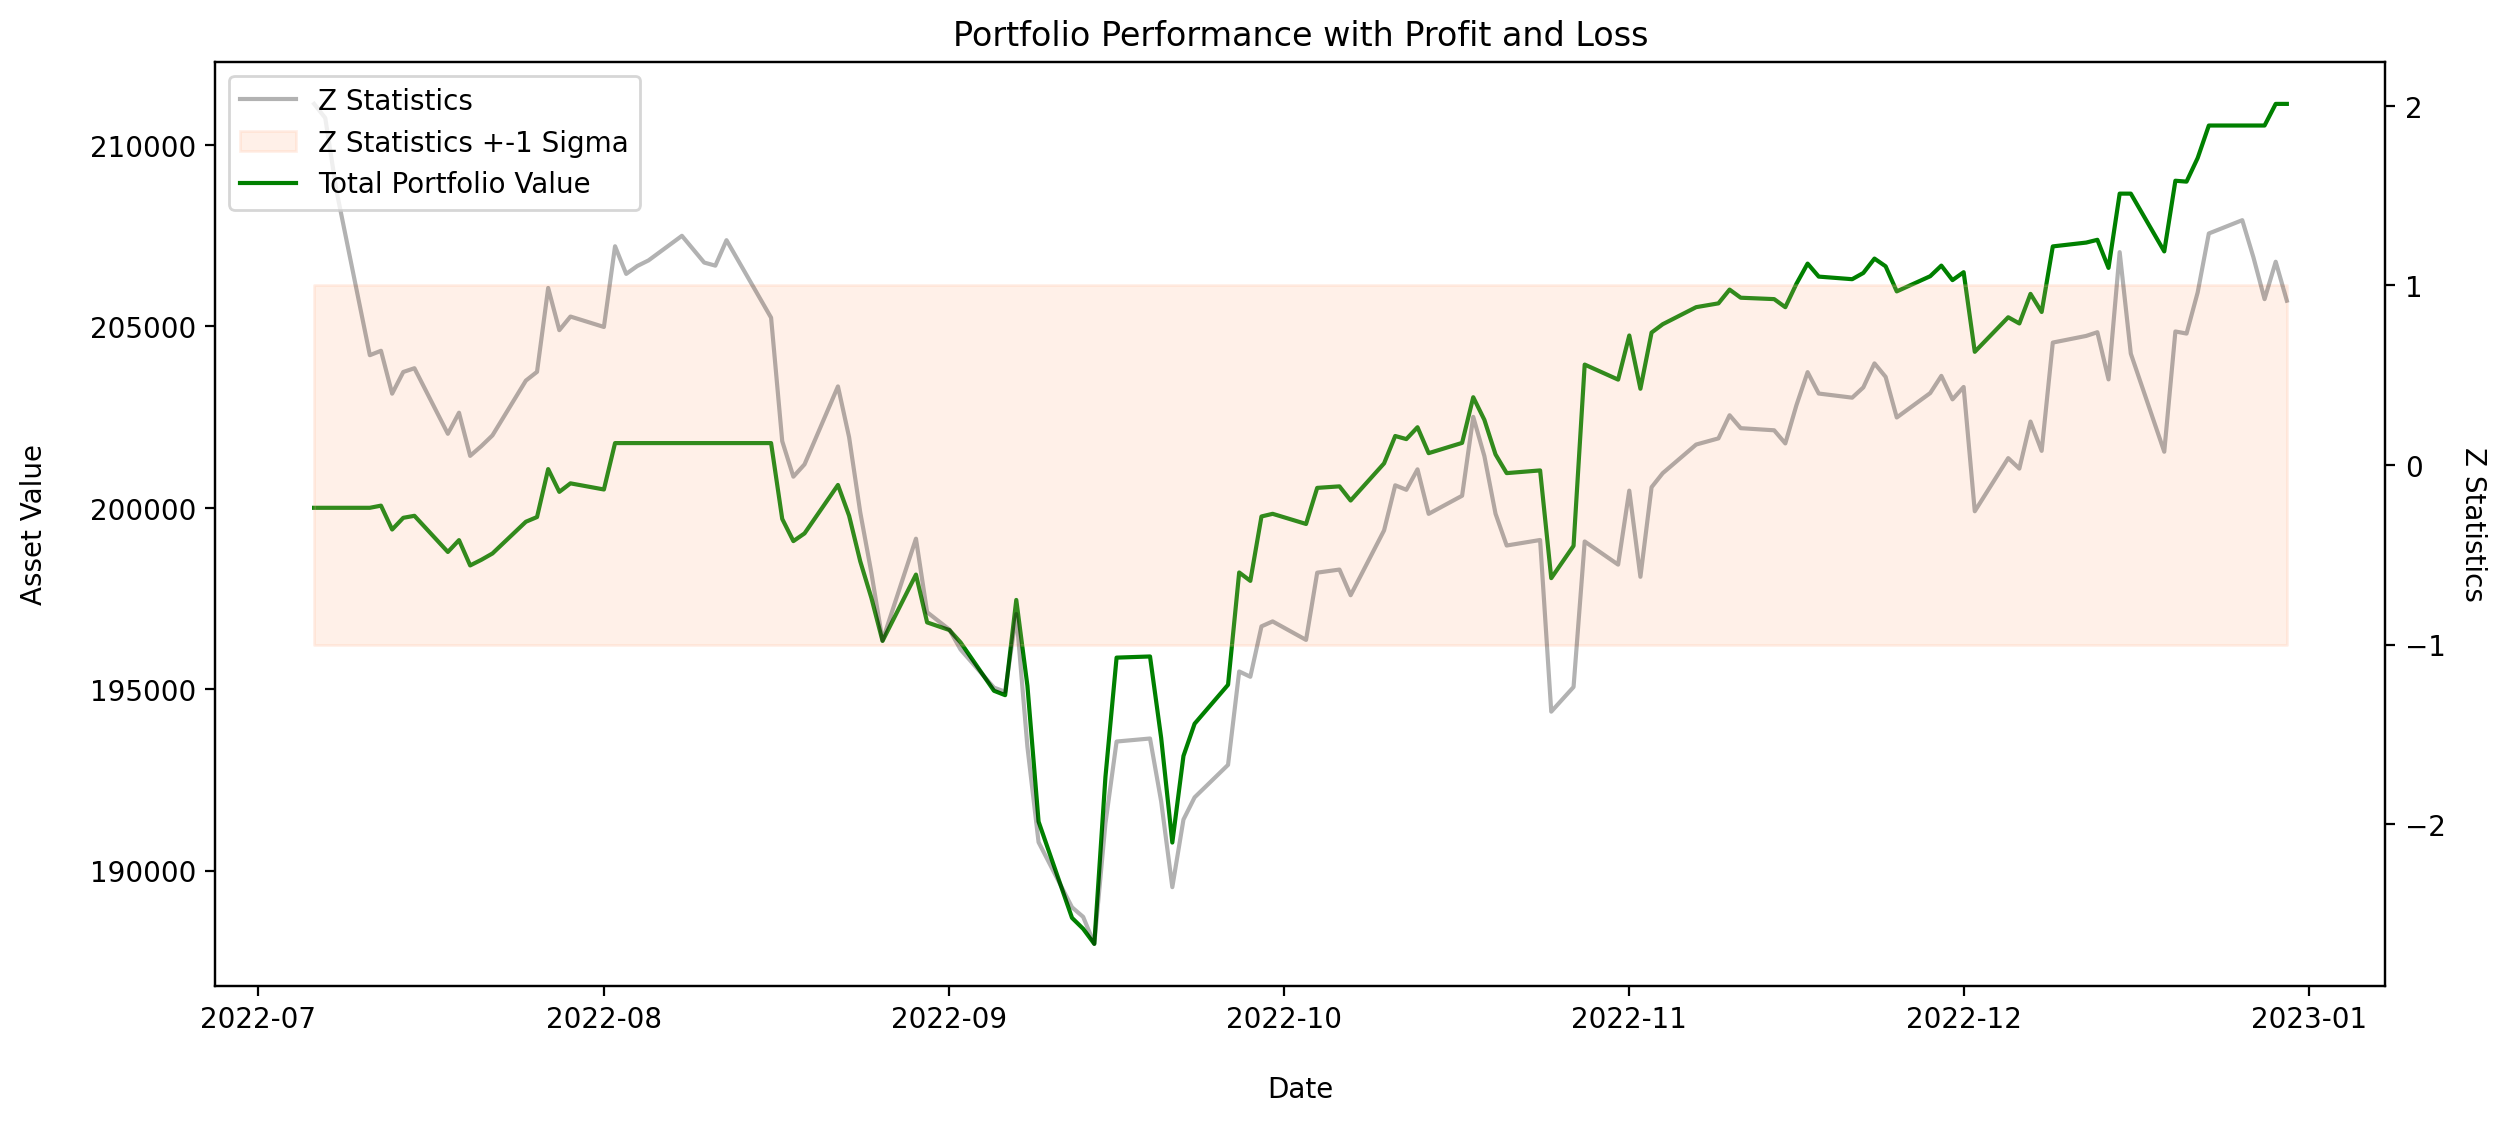

In [37]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');


# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))
